# Analysis of the 4x3 lexicons for the HLC RSA and Non-Ostensive simulations.

Import packages for reading data and generating images

In [1]:
#imports
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import scipy.stats as st
import re
import csv

Below are three methods for reading the outputfiles as Pandas DataFrames

In [2]:
# config.csv:
# agentPairs;maxTurns;roundsPlayed;beta;entropyThreshold;order;costs;initiatorDistribution;responderDistribution
def read_config(location, config_title):
    filename = location + "config" + config_title + ".csv"
    with open(filename) as f:
        config = pd.read_csv(filename, sep=";")
    return config

In [3]:
# results_rounds.csv: 
# pair;round;nrTurns;success
def read_results_rounds(location, config_title):
    filename = location + "results_rounds" + config_title + ".csv"
    with open(filename) as f:
        results_rounds = pd.read_csv(filename, sep=";")
    return results_rounds

In [4]:
# results_turns.csv: 
# pair;round;turn;initiatorIntention;initiatorSignal;responderInference;responderSignal;entropyInitiatorListen;entropyResponderListen;entropyInitiatorLexicon;entropyResponderLexicon;KLDivItoR;KLDivRtoI
def read_results_turns(location, config_title):
    filename = location + "results_turns" + config_title + ".csv"
    with open(filename) as f:
        results_turns = pd.read_csv(filename, sep=";")
    return results_turns

Defining the names and locations of files that I am going to compare. 4x3 lexicon, binomial distribution with X=0.5, alpha=5 and agents=500.

In [5]:
# This is the baseline to compare against
non_ostensive_model_title = "_a500_b5.0_d0.5"
non_ostensive_model_location = "data/S4R3_non_ostensive_a500_b5.0_d0.5/"

# List of all titles and locations
# This list is sorted on neighborliness first
# hlc_rsa_model_title_list = ["_a5_b5.0_d0.5_f0_n0.0",   "_a100_b5.0_d0.5_f1_n0.0", "_a100_b5.0_d0.5_f2_n0.0", "_a100_b5.0_d0.5_f3_n0.0", 
#                             "_a100_b5.0_d0.5_f0_n0.5", "_a100_b5.0_d0.5_f1_n0.5", "_a100_b5.0_d0.5_f2_n0.5", "_a500_b5.0_d0.5_f3_n0.5", 
#                             "_a500_b5.0_d0.5_f0_n0.7", "_a500_b5.0_d0.5_f1_n0.7", "_a500_b5.0_d0.5_f2_n0.7", "_a500_b5.0_d0.5_f3_n0.7", 
#                             "_a500_b5.0_d0.5_f0_n0.9", "_a500_b5.0_d0.5_f1_n0.9", "_a100_b5.0_d0.5_f2_n0.9", "_a500_b5.0_d0.5_f3_n0.9"]

# This list is sorted on facts first
hlc_rsa_model_title_list = ["_a5_b5.0_d0.5_f0_n0.0",   "_a100_b5.0_d0.5_f0_n0.5", "_a500_b5.0_d0.5_f0_n0.7", "_a500_b5.0_d0.5_f0_n0.9", 
                            "_a100_b5.0_d0.5_f1_n0.0", "_a100_b5.0_d0.5_f1_n0.5", "_a500_b5.0_d0.5_f1_n0.7", "_a500_b5.0_d0.5_f1_n0.9", 
                            "_a100_b5.0_d0.5_f2_n0.0", "_a100_b5.0_d0.5_f2_n0.5", "_a500_b5.0_d0.5_f2_n0.7", "_a100_b5.0_d0.5_f2_n0.9", 
                            "_a100_b5.0_d0.5_f3_n0.0", "_a500_b5.0_d0.5_f3_n0.5", "_a500_b5.0_d0.5_f3_n0.7", "_a500_b5.0_d0.5_f3_n0.9"]

hlc_rsa_model_location = "data/S4R3"

# Dictionary for renaming the codelike parameters to meaningful descriptions
dictionary_to_rename_parameters = {
    "a": "Agents",
    "b": "Alpha",
    "d": "X",
    "f": "Facts",
    "n": "Neighborliness",
}

# Looks up the codelike character in the dictionary and replaces that with the descriptive word
def make_human_readable(parameter):
    parameter[0] = dictionary_to_rename_parameters[parameter[0]]
    return parameter

# Splits the parameter string in letters and number. ('a500' becomes 'a', '500')
def split_parameter_string(parameters):
    return [(re.split('(\d.*)', level)[:-1]) for level in parameters]

# Replaces the single letters with the descriptive words
def readable_string(parameters):
    return [make_human_readable(level) for level in parameters]

# Split the title into the seperate parameters, using '_'. "_a500_b5" becomes "a500", "b5"
split_parameters_list = [title.split("_")[1:] for title in hlc_rsa_model_title_list]

# List comprehension that creates a list of lists that contain the names and values for the individual parameters
parameters_list = [readable_string(split_parameter_string(parameters)) for parameters in split_parameters_list]

Importing all the datasets

In [6]:
# Do this only once, baseline is the same every time
non_ostensive_results_turns = read_results_turns(non_ostensive_model_location, non_ostensive_model_title)

# List comprehension to get the results of the turns stored in a list
hlc_rsa_results_turns_list = [read_results_turns(hlc_rsa_model_location + title + "/", title) for title in hlc_rsa_model_title_list]

The labelling of turns is off slightly because of how the models was built, the below code fixes that (do not run it extra without reloading the data, else the +1 row will throw everything off)

In [7]:
# Run this only once after loading the data
for i, row in non_ostensive_results_turns.iterrows():
    if row["turn"] == 0 and np.isnan(row["entropyInitiatorListen"]):
        non_ostensive_results_turns.at[i,"turn"] = -1
non_ostensive_results_turns["turn"] = [x+1 for x in non_ostensive_results_turns["turn"]]

# Running this for all results in the list
for hlc_rsa_results_turns in hlc_rsa_results_turns_list:
    for i, row in hlc_rsa_results_turns.iterrows():
        if row["turn"] == 0 and np.isnan(row["entropyInitiatorListen"]):
            hlc_rsa_results_turns.at[i,"turn"] = -1
    hlc_rsa_results_turns["turn"] = [x+1 for x in hlc_rsa_results_turns["turn"]]

Merging the results of the rounds with that of the turns

In [8]:
# Results of baseline dialogue
non_ostensive_results_rounds = read_results_rounds(non_ostensive_model_location, non_ostensive_model_title)

# List comprehension to get the results of the rounds stored in a list
hlc_rsa_results_rounds_list = [read_results_rounds(hlc_rsa_model_location + title + "/", title) for title in hlc_rsa_model_title_list]

In [9]:
# Baseline
non_ostensive_results_merged = non_ostensive_results_rounds.merge(non_ostensive_results_turns, left_on=['pair', 'round'], right_on=['pair', 'round'])

# List comprehension to get merged results
hlc_rsa_results_merged_list = [rounds.merge(turns, left_on=['pair', 'round'], right_on=['pair', 'round']) for rounds, turns in zip(hlc_rsa_results_rounds_list, hlc_rsa_results_turns_list)]

Adding disambiguation between the models and putting them in one dataframe for some of the image creation.

In [10]:
# Baseline
non_ostensive_results_rounds['model'] = "Non-Ostensive Baseline"

# Combining hlc-rsa with baseline for image creation
for hlc_rsa_results_rounds, parameters in zip(hlc_rsa_results_rounds_list, parameters_list):
    hlc_rsa_results_rounds['model'] = "HLC-RSA\n{}\n{}".format(" = ".join(parameters[3]), " = ".join(parameters[4]))

mixed_results_rounds_list = [pd.concat([hlc_rsa_results_rounds, non_ostensive_results_rounds]) for hlc_rsa_results_rounds in hlc_rsa_results_rounds_list]

Removing all cases where the agents gave up

In [11]:
for mixed_results_rounds in mixed_results_rounds_list:
    mixed_results_rounds = mixed_results_rounds[mixed_results_rounds['nrTurns'] < 7]

Creating the baseline image, this has only one model in it

Text(0.5, 1.0, 'Reduction of turn sequence length')

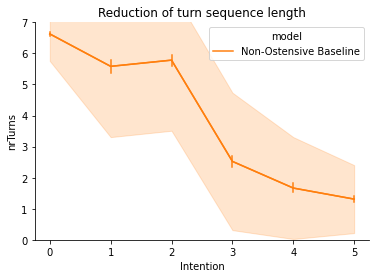

In [12]:
colorDict = {"Non-Ostensive Baseline" : "#ff7f0e"}
plt.figure()
f = sns.lineplot(data=non_ostensive_results_rounds, x="round", y="nrTurns", hue="model", err_style="bars", palette=colorDict)
c = sns.lineplot(data=non_ostensive_results_rounds, x="round", y="nrTurns", hue="model", ci='sd', palette=colorDict, legend=False)
sns.despine()
f.set_ylim([0,7])
f.set_xlabel("Intention")
f.set_title("Reduction of turn sequence length")
#plt.savefig(fname="images/analysis 1/non-ostensive.jpg")

Creating all images for analysis 1. The clarification sequence length that the agents needed

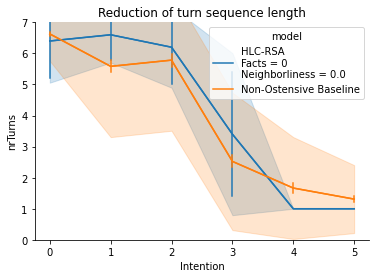

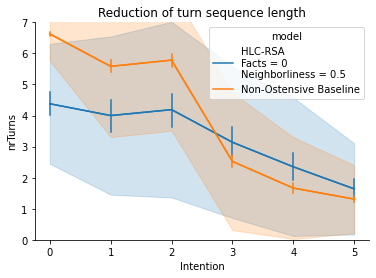

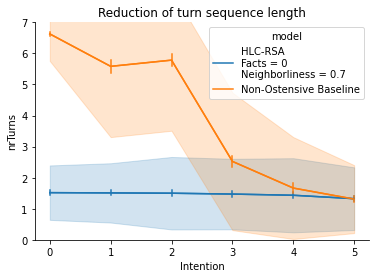

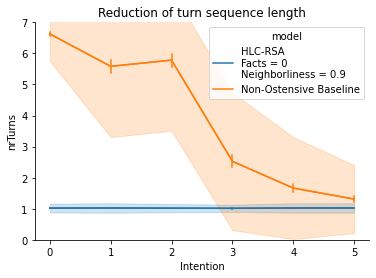

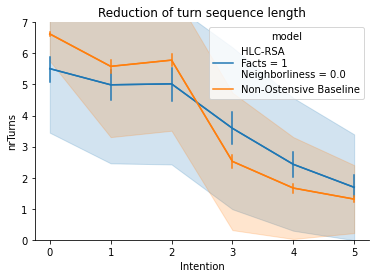

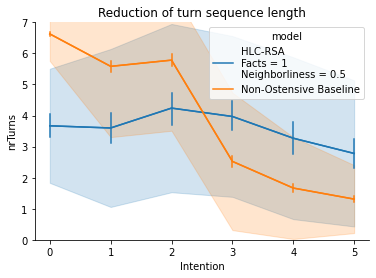

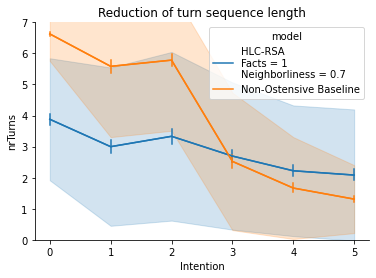

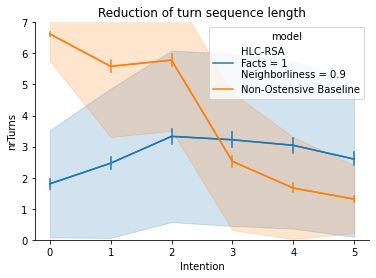

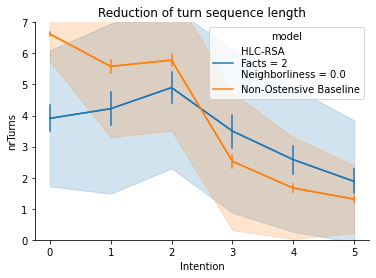

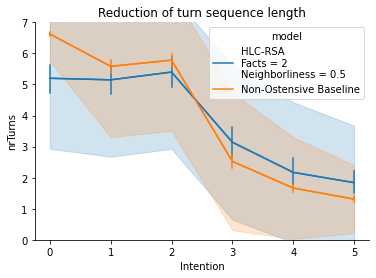

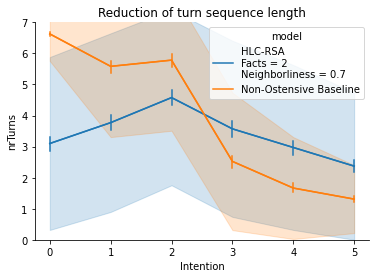

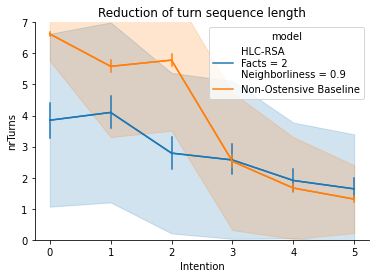

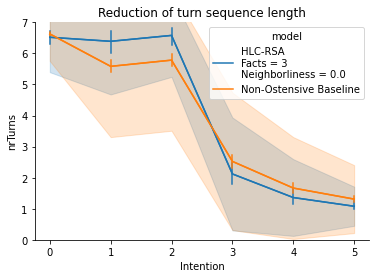

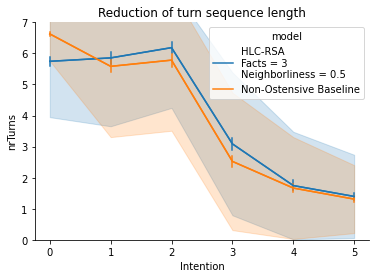

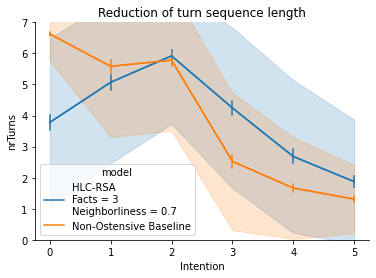

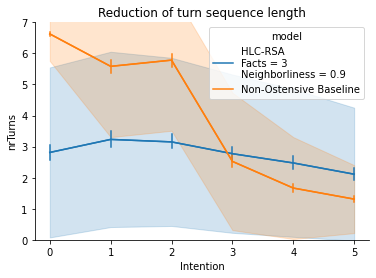

In [14]:
path = "images/analysis 1/"
for mixed_results_rounds, title in zip(mixed_results_rounds_list, hlc_rsa_model_title_list):
    plt.figure()
    f = sns.lineplot(data=mixed_results_rounds, x="round", y="nrTurns", hue="model", err_style="bars")
    c = sns.lineplot(data=mixed_results_rounds, x="round", y="nrTurns", hue="model", ci='sd', legend=False)
    sns.despine()
    f.set_ylim([0,7])
    f.set_xlabel("Intention")
    f.set_title("Reduction of turn sequence length")
    name = path + title + ".jpg"
    #plt.savefig(fname=name)

The images for analysis 2. The factual understanding for each model

<Figure size 432x288 with 0 Axes>

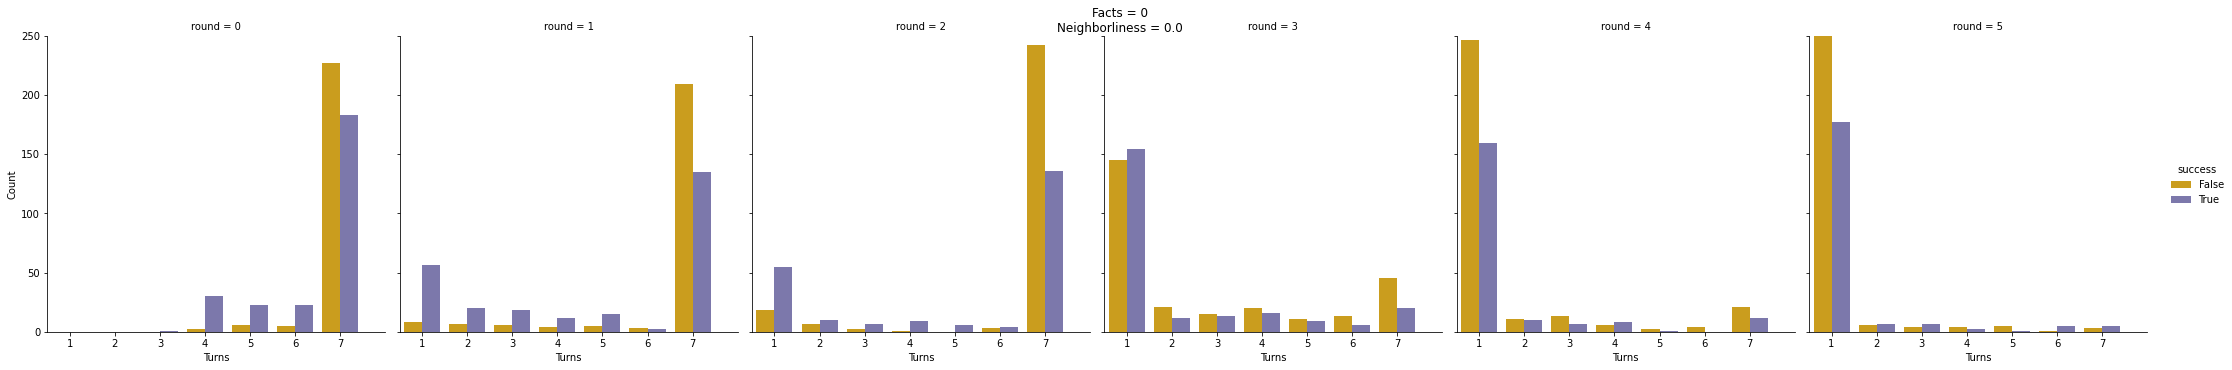

In [15]:
# Baseline non-ostensive
plt.figure()
f = sns.catplot(x="nrTurns", hue="success", col="round", data=non_ostensive_results_rounds, kind="count", palette="Dark2_r")
(f.set_axis_labels("Turns", "Count")
  .set(ylim=(0, 250))
  .set(xlim=(-0.5, 7)))
f.fig.subplots_adjust(top=0.9)
f.fig.suptitle("Facts = 0\nNeighborliness = 0.0")
#plt.savefig(fname="images/analysis 2/non-ostensive.jpg")

For loop to create all images. These images are compounded into two large images in my thesis

<ipython-input-16-8906b3f8c785>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<Figure size 432x288 with 0 Axes>

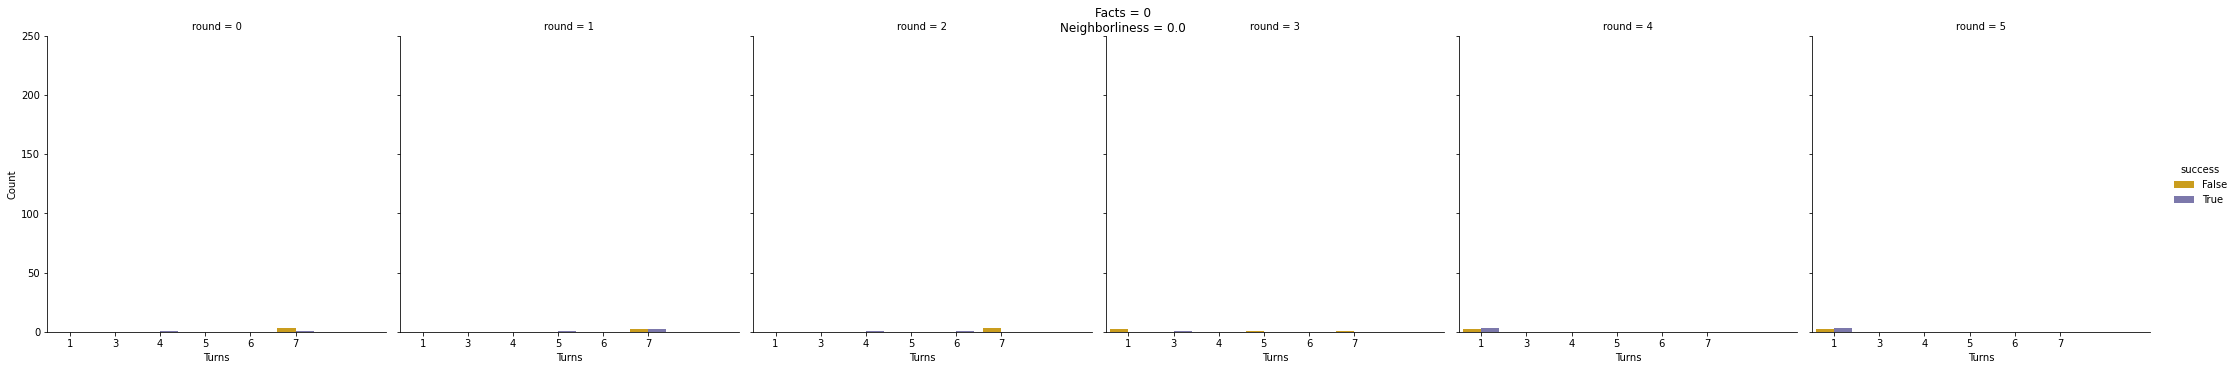

<Figure size 432x288 with 0 Axes>

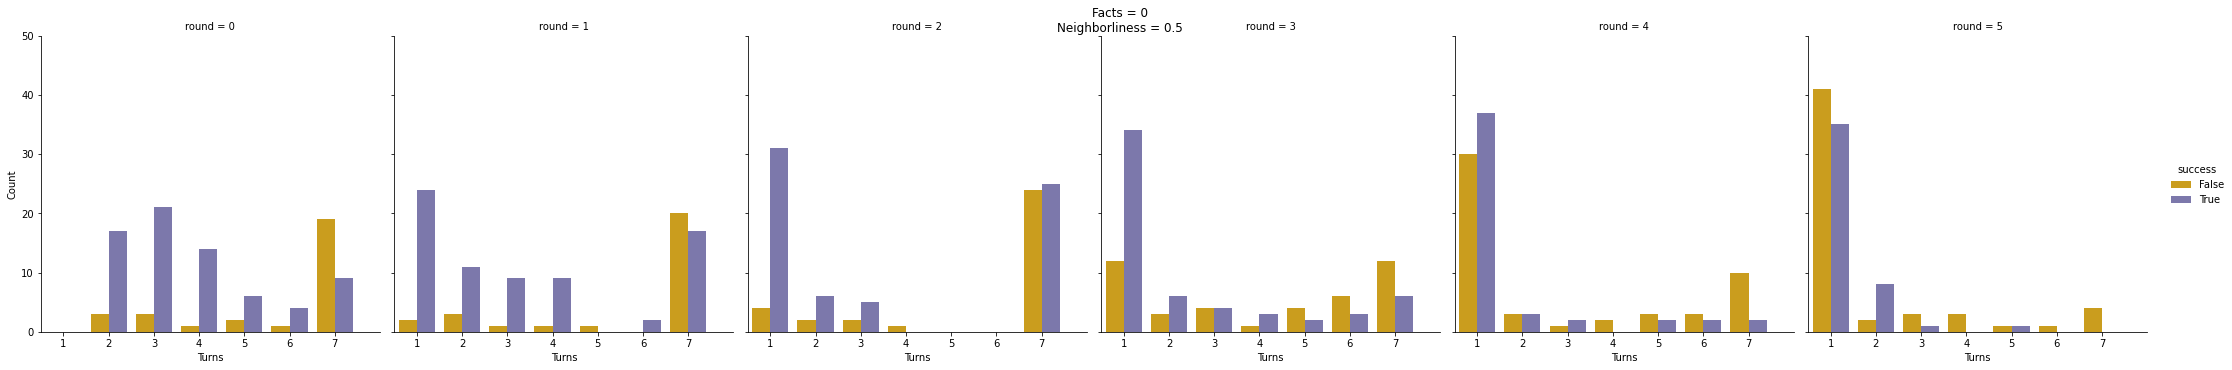

<Figure size 432x288 with 0 Axes>

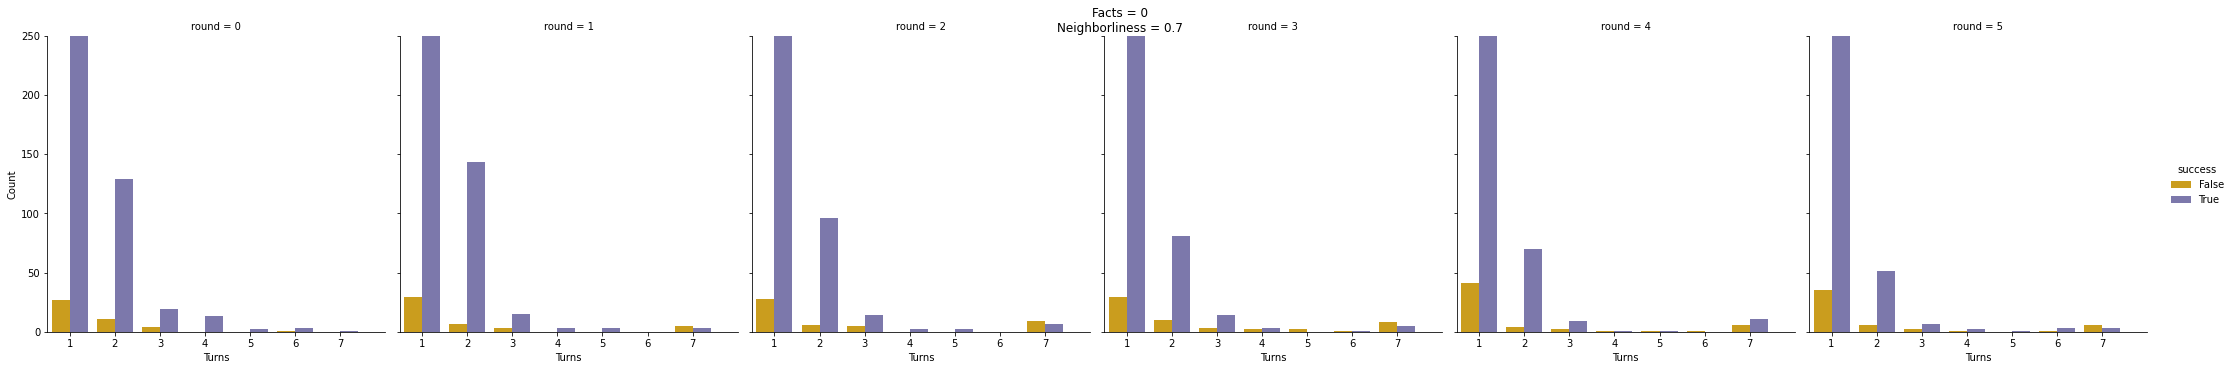

<Figure size 432x288 with 0 Axes>

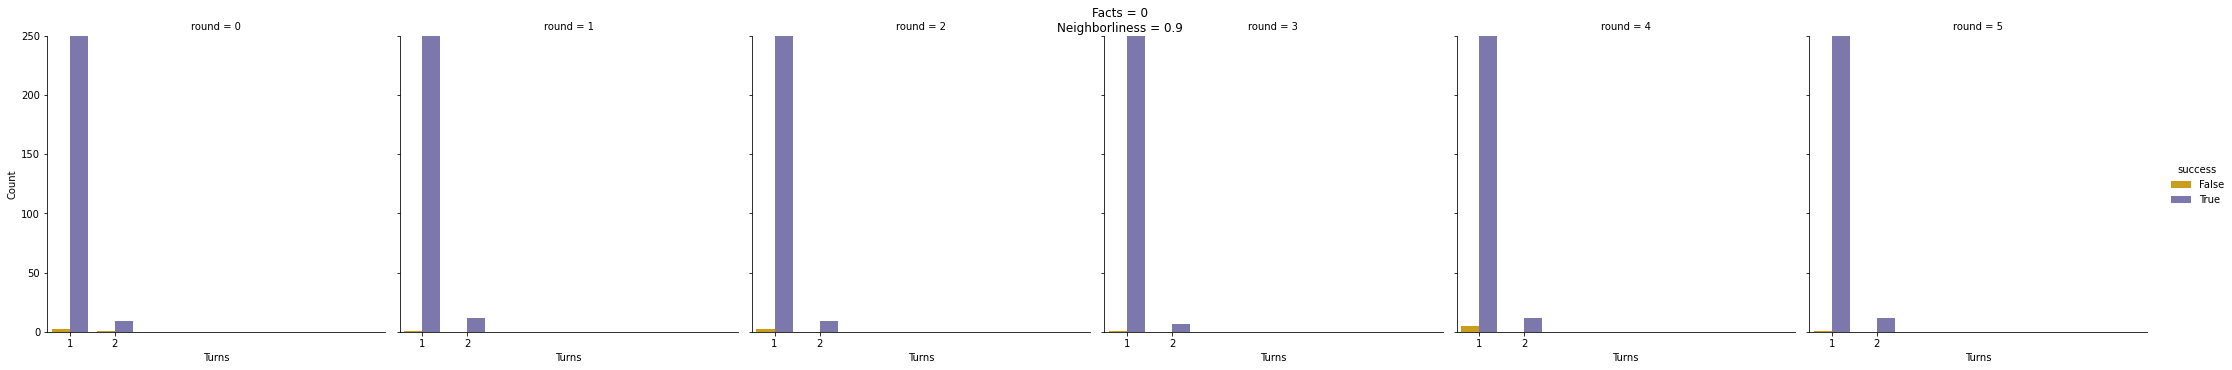

<Figure size 432x288 with 0 Axes>

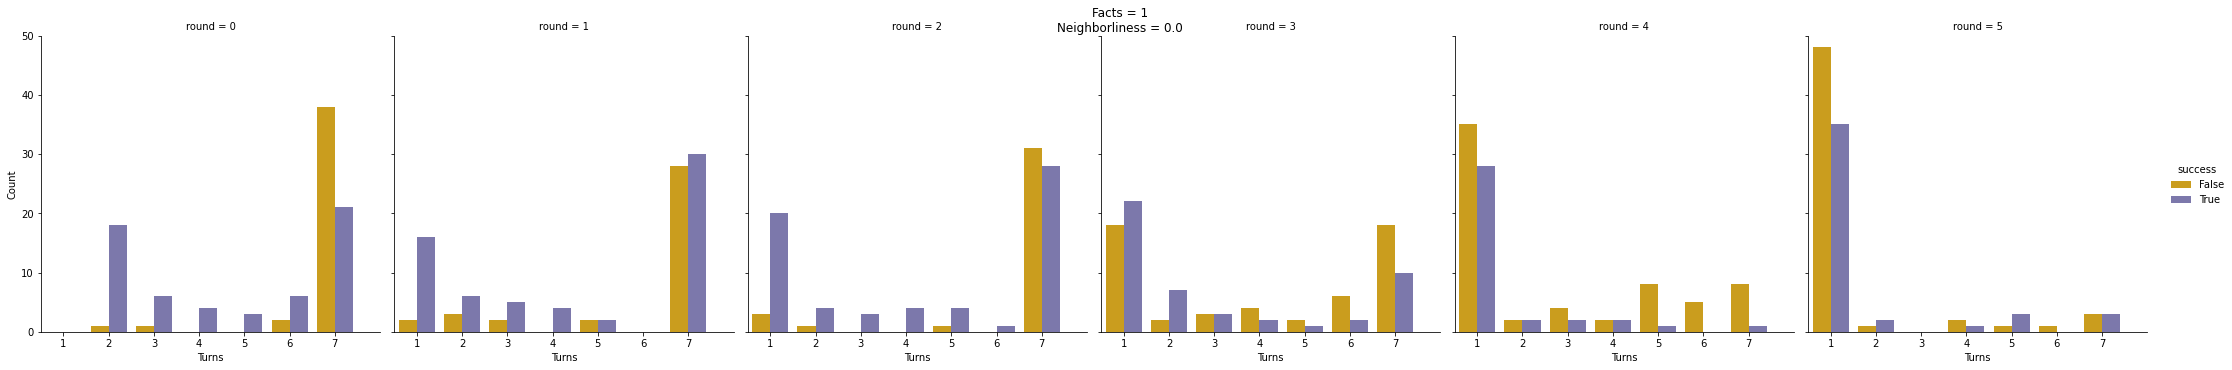

<Figure size 432x288 with 0 Axes>

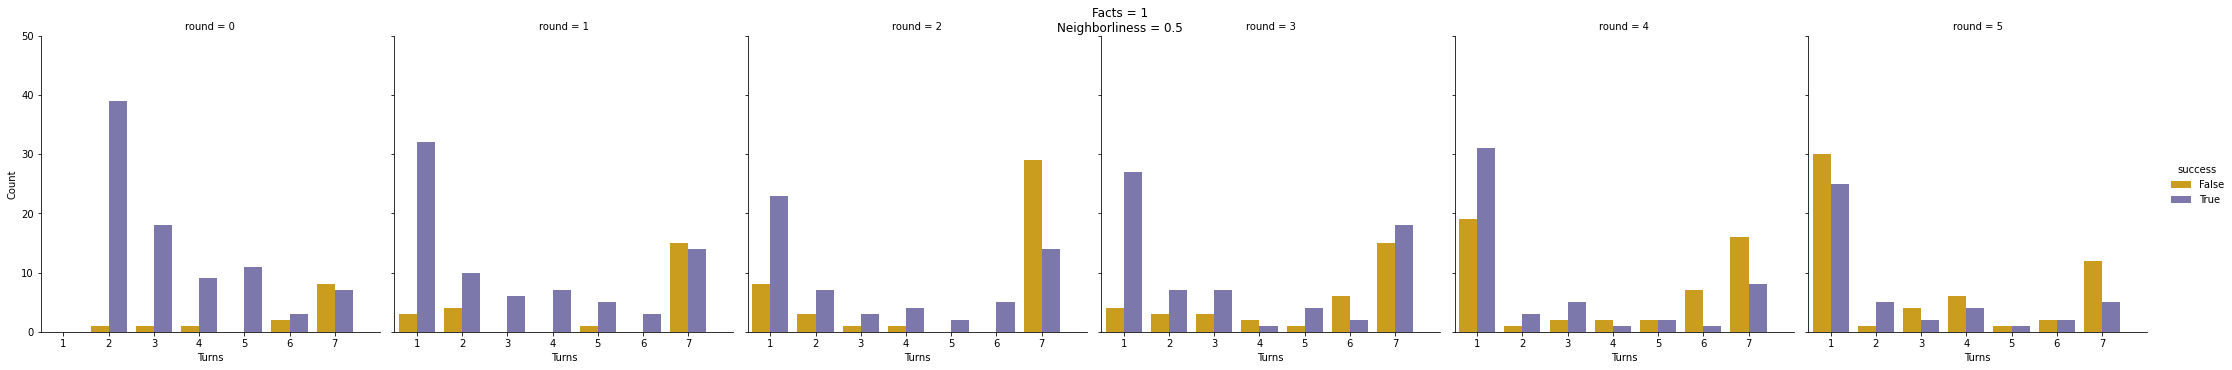

<Figure size 432x288 with 0 Axes>

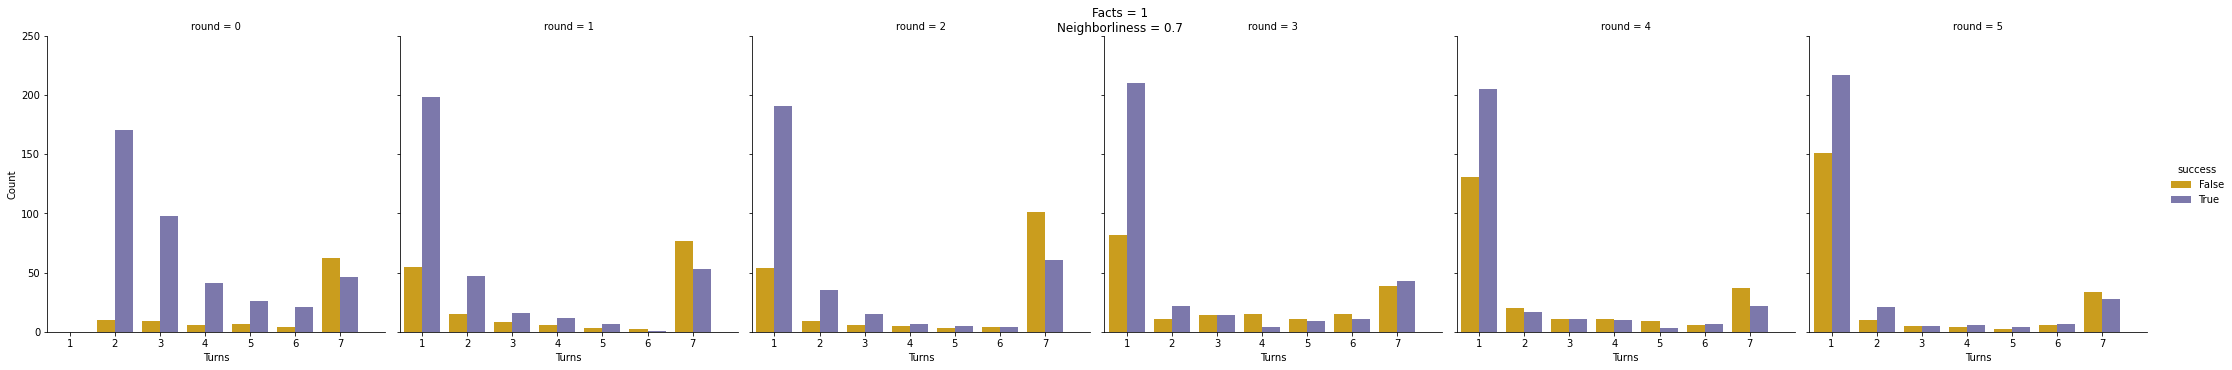

<Figure size 432x288 with 0 Axes>

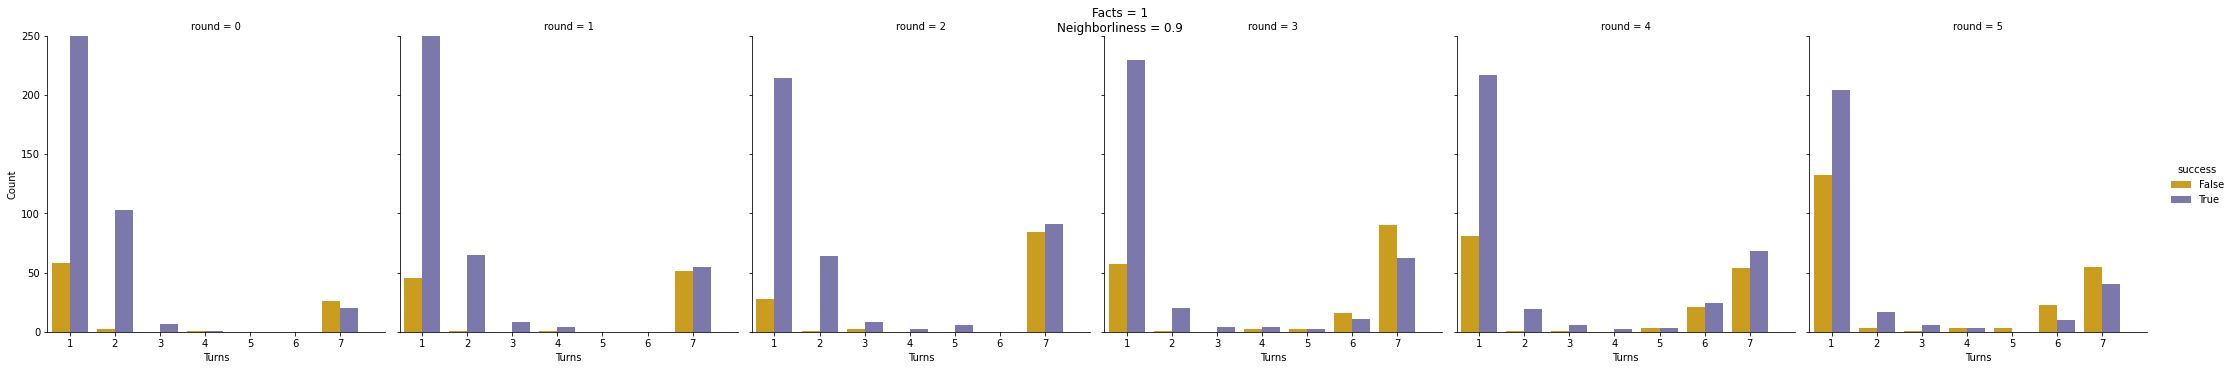

<Figure size 432x288 with 0 Axes>

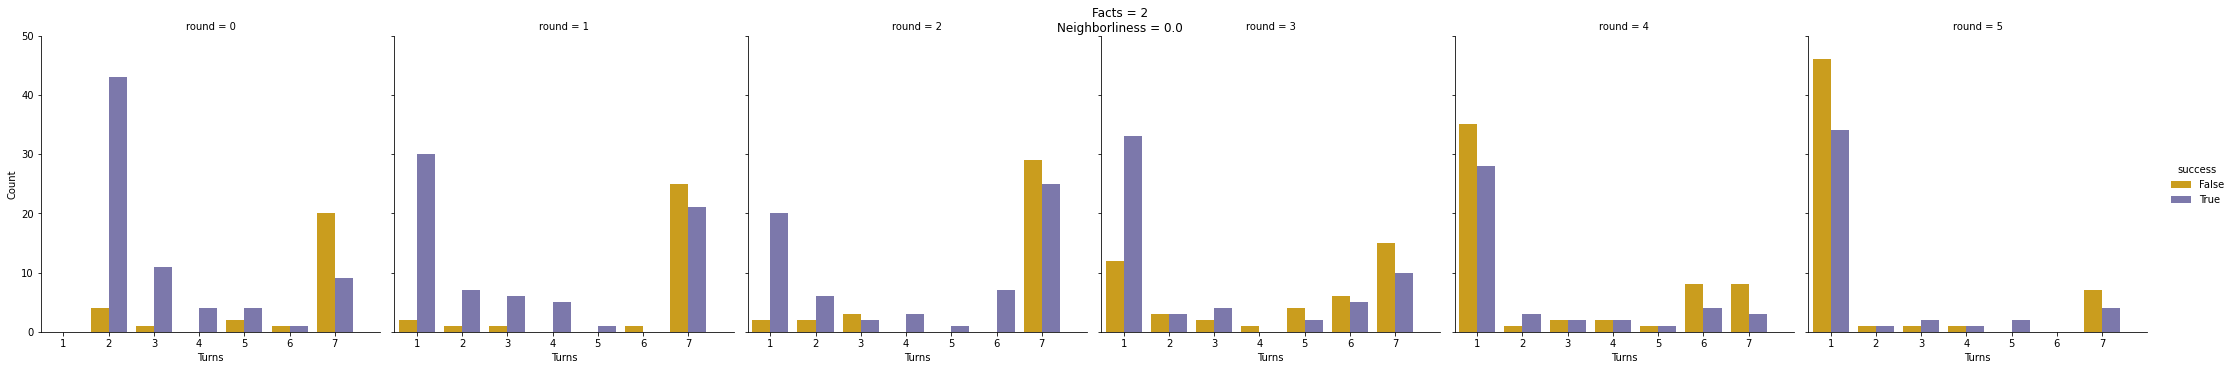

<Figure size 432x288 with 0 Axes>

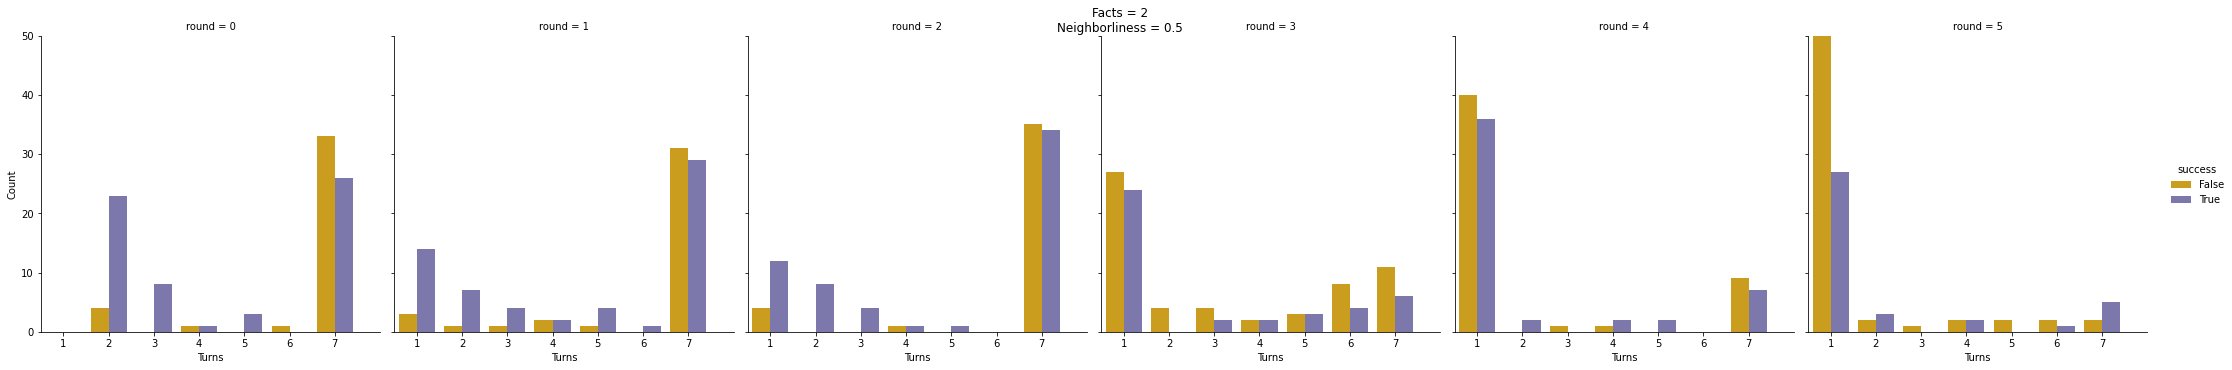

<Figure size 432x288 with 0 Axes>

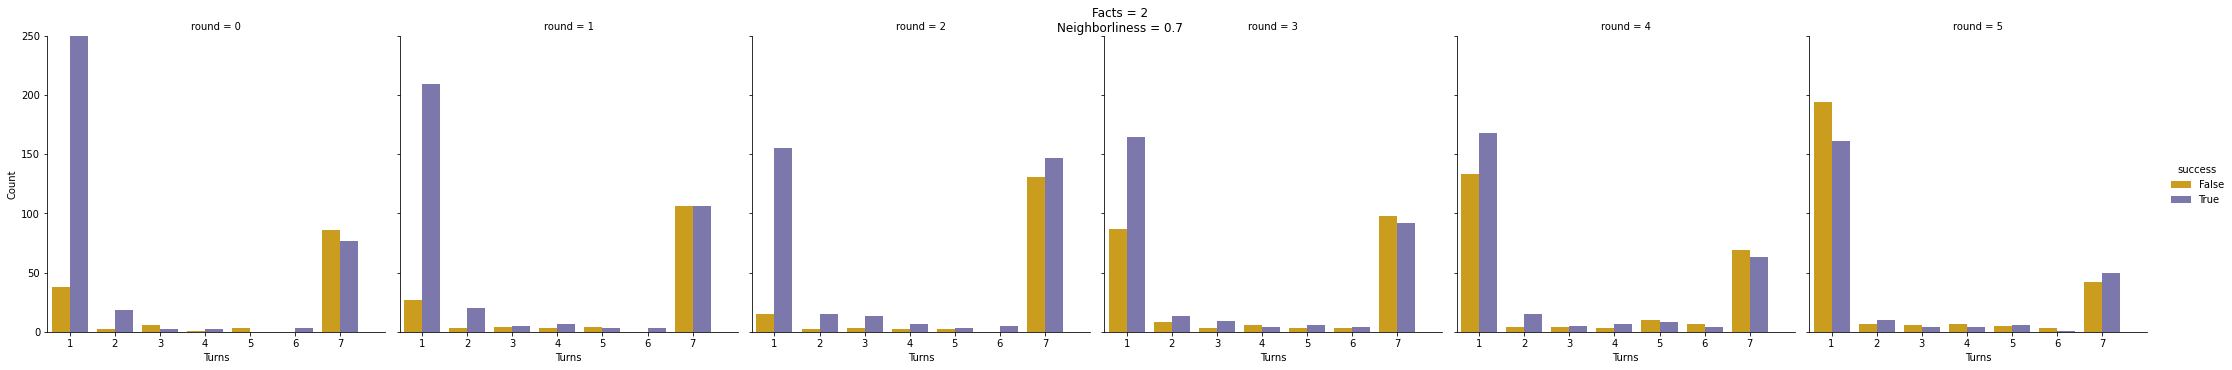

<Figure size 432x288 with 0 Axes>

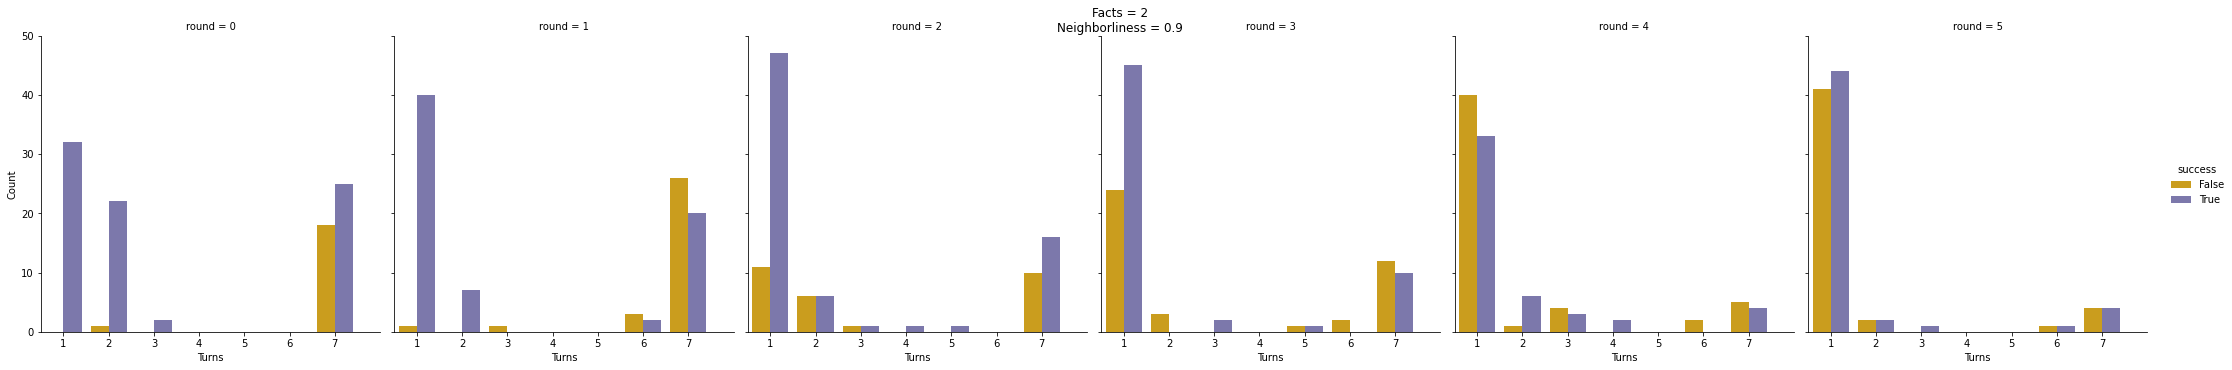

<Figure size 432x288 with 0 Axes>

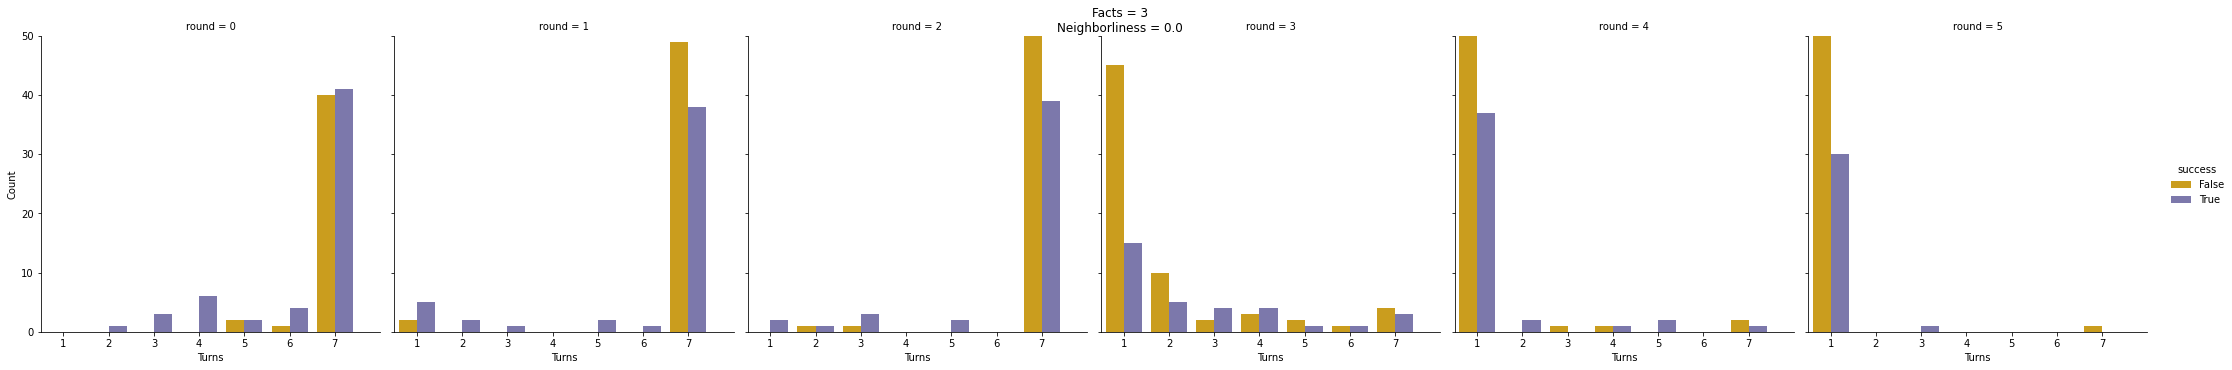

<Figure size 432x288 with 0 Axes>

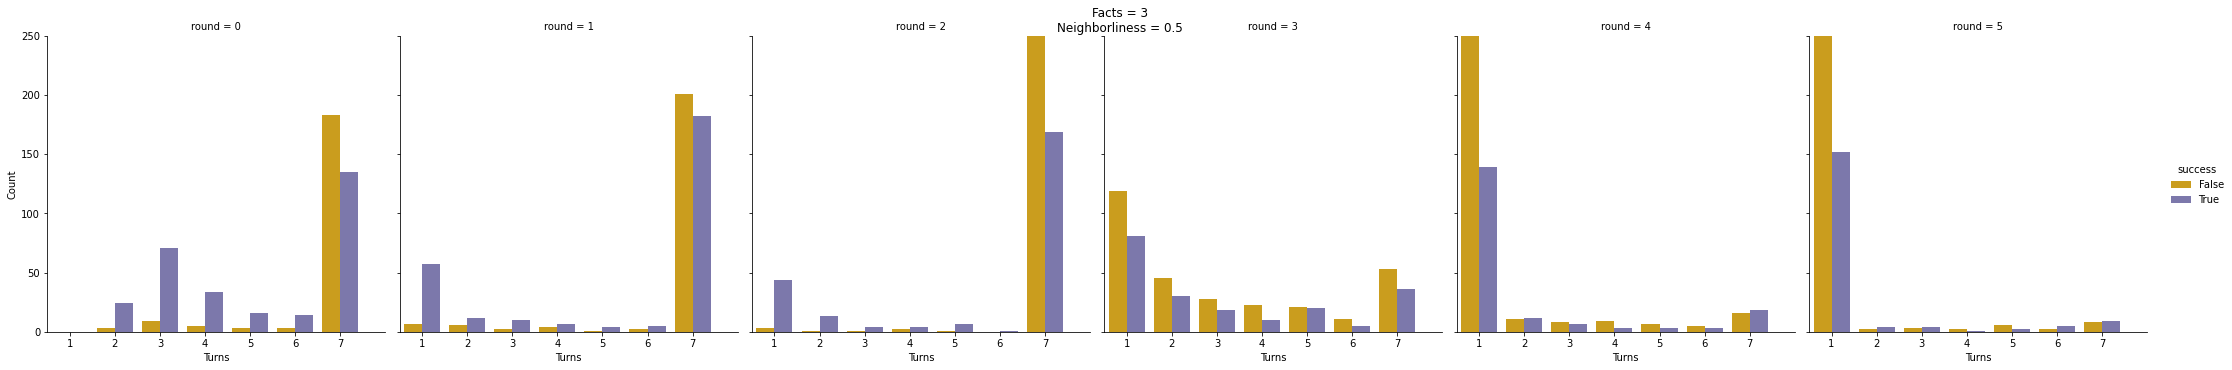

<Figure size 432x288 with 0 Axes>

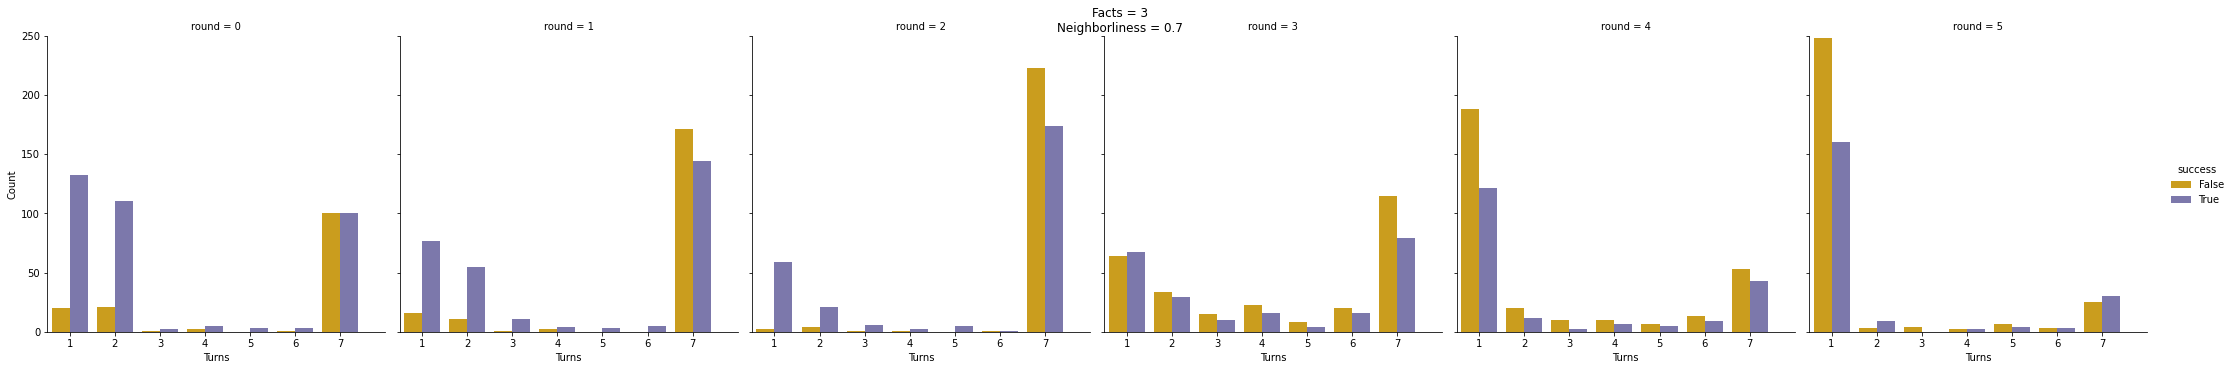

<Figure size 432x288 with 0 Axes>

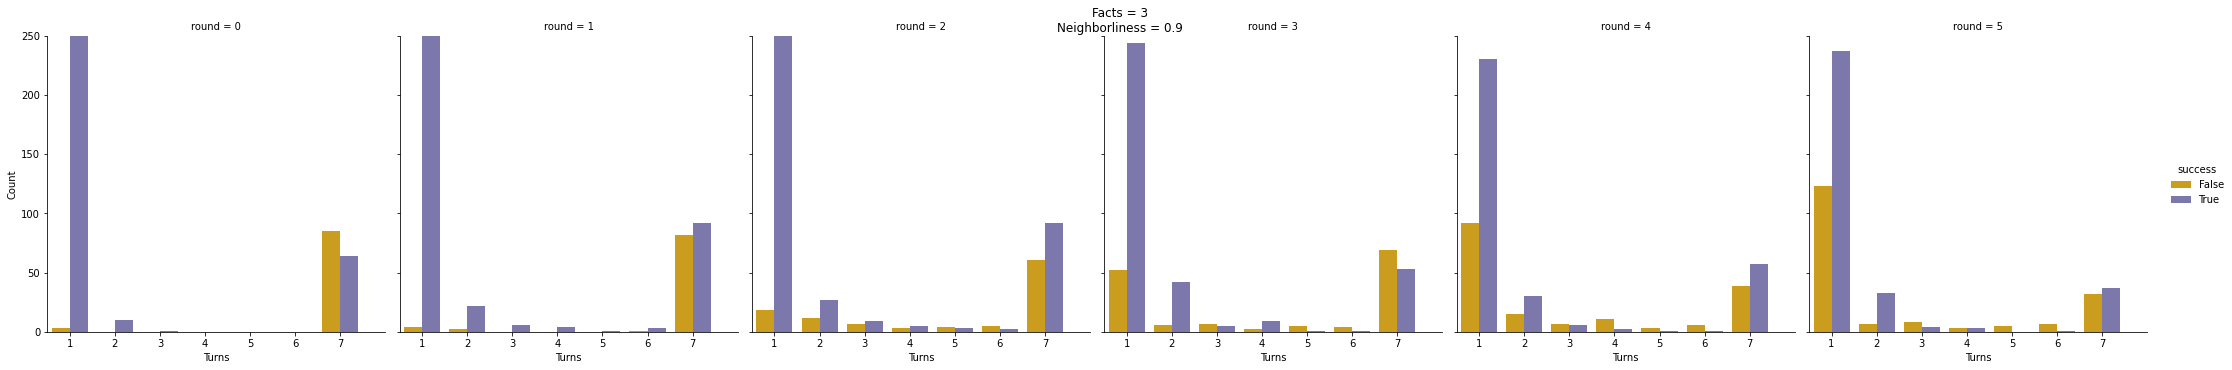

In [16]:
path = "images/analysis 2/adjusted/"
for hlc_rsa_results_rounds, parameters, title in zip(hlc_rsa_results_rounds_list, parameters_list, hlc_rsa_model_title_list):
    plt.figure() 
    f = sns.catplot(x="nrTurns", hue="success", col="round", data=hlc_rsa_results_rounds, kind="count", palette="Dark2_r")
    if(parameters[0][1] == "100"):
        (f.set_axis_labels("Turns", "Count").set(ylim=(0, 50)).set(xlim=(-0.5, 7)))
    else:
        (f.set_axis_labels("Turns", "Count").set(ylim=(0, 250)).set(xlim=(-0.5, 7)))
    f.fig.subplots_adjust(top=0.9)
    f.fig.suptitle("{}\n{}".format(" = ".join(parameters[3]), " = ".join(parameters[4])))
    name = path + title + ".jpg"
    #plt.savefig(fname=name)

Analysis 3 is for the percentual perceived understanding for all models. Only the final set of tables is relevant for the thesis

Non-Ostensive baseline

In [17]:
non_ostensive_understanding_table = [[0, 0], [0, 0]]
perceived_understanding_non_ostensive = non_ostensive_results_rounds[non_ostensive_results_rounds.nrTurns <= 6]
perceived_misunderstanding_non_ostensive = non_ostensive_results_rounds[non_ostensive_results_rounds.nrTurns > 6]
non_ostensive_understanding_table[0][0] = perceived_understanding_non_ostensive[perceived_understanding_non_ostensive.success == True].count(1).size
non_ostensive_understanding_table[0][1] = perceived_understanding_non_ostensive[perceived_understanding_non_ostensive.success == False].count(1).size
non_ostensive_understanding_table[1][0] = perceived_misunderstanding_non_ostensive[perceived_misunderstanding_non_ostensive.success == True].count(1).size
non_ostensive_understanding_table[1][1] = perceived_misunderstanding_non_ostensive[perceived_misunderstanding_non_ostensive.success == False].count(1).size
print("Non-Ostensive\t\t | Perceived understanding | Give up")
print("-------------------------|-------------------------|--------")
print("Factual understanding\t | {}\t\t\t   | {}".format(non_ostensive_understanding_table[0][0], non_ostensive_understanding_table[1][0]))
print("-------------------------|-------------------------|--------")
print("Factual misunderstanding | {}\t\t\t   | {}\n".format(non_ostensive_understanding_table[0][1], non_ostensive_understanding_table[1][1]))

Non-Ostensive		 | Perceived understanding | Give up
-------------------------|-------------------------|--------
Factual understanding	 | 885			   | 491
-------------------------|-------------------------|--------
Factual misunderstanding | 877			   | 747



And for the HLC-RSA case

In [18]:
combined_list = []
for hlc_rsa_results_rounds, parameters in zip(hlc_rsa_results_rounds_list, parameters_list):
    temp_table = [[0, 0], [0, 0]]
    perceived_understanding_hlc_rsa = hlc_rsa_results_rounds[hlc_rsa_results_rounds.nrTurns <= 6]
    perceived_misunderstanding_hlc_rsa = hlc_rsa_results_rounds[hlc_rsa_results_rounds.nrTurns > 6]
    temp_table[0][0] = perceived_understanding_hlc_rsa[perceived_understanding_hlc_rsa.success == True].count(1).size
    temp_table[0][1] = perceived_understanding_hlc_rsa[perceived_understanding_hlc_rsa.success == False].count(1).size
    temp_table[1][0] = perceived_misunderstanding_hlc_rsa[perceived_misunderstanding_hlc_rsa.success == True].count(1).size
    temp_table[1][1] = perceived_misunderstanding_hlc_rsa[perceived_misunderstanding_hlc_rsa.success == False].count(1).size
    params = "{}\n{}".format(" = ".join(parameters[3]), " = ".join(parameters[4]))
    hlc_rsa_understanding_tables = temp_table
    combined_list.append((params, hlc_rsa_understanding_tables))

In [19]:
def print_combined_table(combined_table):
    model, table = combined_table
    print("{}\t | Perceived understanding | Give up".format(model))
    print("-------------------------|-------------------------|--------")
    print("Factual understanding\t | {}\t\t\t   | {}".format(table[0][0], table[1][0]))
    print("-------------------------|-------------------------|--------")
    print("Factual misunderstanding | {}\t\t\t   | {}\n".format(table[0][1], table[1][1]))
    
for combined_table in combined_list:
    print_combined_table(combined_table)

Facts = 0
Neighborliness = 0.0	 | Perceived understanding | Give up
-------------------------|-------------------------|--------
Factual understanding	 | 11			   | 3
-------------------------|-------------------------|--------
Factual misunderstanding | 7			   | 9

Facts = 0
Neighborliness = 0.5	 | Perceived understanding | Give up
-------------------------|-------------------------|--------
Factual understanding	 | 302			   | 59
-------------------------|-------------------------|--------
Factual misunderstanding | 150			   | 89

Facts = 0
Neighborliness = 0.7	 | Perceived understanding | Give up
-------------------------|-------------------------|--------
Factual understanding	 | 2673			   | 30
-------------------------|-------------------------|--------
Factual misunderstanding | 263			   | 34

Facts = 0
Neighborliness = 0.9	 | Perceived understanding | Give up
-------------------------|-------------------------|--------
Factual understanding	 | 2987			   | 0
-----------------------

In percentages:

In [20]:
def table_to_percentage(table):
    total = sum(sum(x) for x in table)
    percentage_table = [[0, 0], [0, 0]]
    percentage_table[0][0] = table[0][0] / total * 100.0
    percentage_table[0][1] = table[0][1] / total * 100.0
    percentage_table[1][0] = table[1][0] / total * 100.0
    percentage_table[1][1] = table[1][1] / total * 100.0
    return percentage_table

def print_percentage_table(combined_percentage_table):
    model, table = combined_percentage_table
    print("{}\t | Perceived understanding | Give up".format(model))
    print("-------------------------|-------------------------|--------")
    print("Factual understanding\t | {:.2f} %\t\t   | {:.2f} %".format(table[0][0], table[1][0]))
    print("-------------------------|-------------------------|--------")
    print("Factual misunderstanding | {:.2f} %\t\t   | {:.2f} %\n".format(table[0][1], table[1][1]))

Baseline

In [21]:
non_ostensive_percentage_table = table_to_percentage(non_ostensive_understanding_table)
print_percentage_table(("Non-Ostensive\nbaseline\t", non_ostensive_percentage_table))

Non-Ostensive
baseline		 | Perceived understanding | Give up
-------------------------|-------------------------|--------
Factual understanding	 | 29.50 %		   | 16.37 %
-------------------------|-------------------------|--------
Factual misunderstanding | 29.23 %		   | 24.90 %



HLC-RSA

In [22]:
for combined_table in combined_list:
    model, table = combined_table
    combined_percentage_table = (model, table_to_percentage(table))
    print_percentage_table(combined_percentage_table)

Facts = 0
Neighborliness = 0.0	 | Perceived understanding | Give up
-------------------------|-------------------------|--------
Factual understanding	 | 36.67 %		   | 10.00 %
-------------------------|-------------------------|--------
Factual misunderstanding | 23.33 %		   | 30.00 %

Facts = 0
Neighborliness = 0.5	 | Perceived understanding | Give up
-------------------------|-------------------------|--------
Factual understanding	 | 50.33 %		   | 9.83 %
-------------------------|-------------------------|--------
Factual misunderstanding | 25.00 %		   | 14.83 %

Facts = 0
Neighborliness = 0.7	 | Perceived understanding | Give up
-------------------------|-------------------------|--------
Factual understanding	 | 89.10 %		   | 1.00 %
-------------------------|-------------------------|--------
Factual misunderstanding | 8.77 %		   | 1.13 %

Facts = 0
Neighborliness = 0.9	 | Perceived understanding | Give up
-------------------------|-------------------------|--------
Factual unders

Below is the final analysis 3: showing percentage of factual understanding split by whether the agents perceived understanding or gave up.

In [23]:
def table_to_percentage_split(table):
    result = [0, 0]
    total_perceived = table[0][0] + table[0][1]
    total_give_up = table[1][0] + table[1][1]
    if(total_perceived != 0):
        result[0] = table[0][0] / total_perceived * 100
    if(total_give_up != 0):
        result[1] = table[1][0] / total_give_up * 100
    return result

non_ostensive_result = table_to_percentage_split(non_ostensive_understanding_table)

# Use this when the list is sorted on facts first
with open("percentage_csv_facts.csv", 'w') as f:
    writer=csv.writer(f, delimiter=',',lineterminator='\n')
    writer.writerow(["Facts", "Neighborliness", "Perceived understanding", "Give up"])
    for (_, table), params in zip(combined_list, parameters_list):
        _, table = (_, table)
        row = []
        result = table_to_percentage_split(table)
        row.append(int(params[3][1]))
        row.append(round(float(params[4][1]), 2))
        row.append(str(round(result[0], 2)) + ' %')
        row.append(str(round(result[1], 2)) + ' %')
        writer.writerow(row)

# Use this when the list is sorted on neighborliness first
# with open("percentage_csv_neighborliness.csv", 'w') as f:
#     writer=csv.writer(f, delimiter=',',lineterminator='\n')
#     writer.writerow(["Neighborliness", "Facts", "Perceived understanding", "Give up"])
#     for (_, table), params in zip(combined_list, parameters_list):
#         _, table = (_, table)
#         row = []
#         result = table_to_percentage_split(table)
#         row.append(round(float(params[4][1]), 2))
#         row.append(int(params[3][1]))
#         row.append(str(round(result[0], 2)) + ' %')
#         row.append(str(round(result[1], 2)) + ' %')
#         writer.writerow(row)

for model, table in combined_list:
    result = table_to_percentage_split(table)
    print("{}\t | Perceived understanding | Give up".format(model))
    print("-------------------------|-------------------------|--------")
    print("RSA-HLC\t\t\t | {:.2f} %\t\t   | {:.2f} %".format(result[0], result[1]))
    print("-------------------------|-------------------------|--------")
    print("Non-Ostensive\t\t | {:.2f} %\t\t   | {:.2f} %".format(non_ostensive_result[0], non_ostensive_result[1]))
    print()
    
    

Facts = 0
Neighborliness = 0.0	 | Perceived understanding | Give up
-------------------------|-------------------------|--------
RSA-HLC			 | 61.11 %		   | 25.00 %
-------------------------|-------------------------|--------
Non-Ostensive		 | 50.23 %		   | 39.66 %

Facts = 0
Neighborliness = 0.5	 | Perceived understanding | Give up
-------------------------|-------------------------|--------
RSA-HLC			 | 66.81 %		   | 39.86 %
-------------------------|-------------------------|--------
Non-Ostensive		 | 50.23 %		   | 39.66 %

Facts = 0
Neighborliness = 0.7	 | Perceived understanding | Give up
-------------------------|-------------------------|--------
RSA-HLC			 | 91.04 %		   | 46.88 %
-------------------------|-------------------------|--------
Non-Ostensive		 | 50.23 %		   | 39.66 %

Facts = 0
Neighborliness = 0.9	 | Perceived understanding | Give up
-------------------------|-------------------------|--------
RSA-HLC			 | 99.57 %		   | 0.00 %
-------------------------|-------------

In [24]:
print(non_ostensive_result)

[50.227014755959146, 39.66074313408724]
